- 참고(CAM 이론): https://tyami.github.io/deep%20learning/CNN-visualization-Grad-CAM/
- 참고(CNN 이론): https://tyami.github.io/medical%20image%20analysis/MEDIA-5-classification-for-medical-image-3-CNN/
- 참고(): 

# 프로젝트: CAM을 만들고 평가해 보자

## 라이브러리 버전 확인하기
---
사용할 라이브러리 버전을 확인해봐요.

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import cv2
import PIL

import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)

tf.config.list_physical_devices('GPU')

/Users/louan/.pyenv/versions/3.9.13/envs/img/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.11.0
1.24.1
4.7.0
9.4.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## CAM 구현하기
---
1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

- CAM의 구조: 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성

- Image Handling
- 사용할 데이터셋: 스탠포드 dogs

In [6]:
# image load
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True)

In [11]:
# <Pooling options>: https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/VGG19
# avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
# max means that global max pooling will be applied.
num_classes = ds_info.features['label'].num_classes

vgg19_base_model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg', 
)
x = vgg19_base_model.output
x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = tf.keras.Model(inputs = vgg19_base_model.input, outputs = x)

In [12]:
cam_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

#### image processing

In [ ]:
# tf.cast 함수: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=wideeyed&logNo=221158018178

def normalize_and_resize_img(input):
    '''
    stanfor_dog의 image item 하나를 받아서 image를 resize, normalize하고 텐서로 변환 후 image와 label return
    '''
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


2023-03-11 17:35:03.679474: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [15]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

- 위와 같이 진행해도 되나.. 시간관계상 model을 불러옴

In [17]:
cam_model = tf.keras.models.load_model('../data/230306/cam_pretrained_model.h5')

In [18]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [22]:
import copy
# copy, deep copy: https://wikidocs.net/16038
def generate_cam(model, item):
    item = copy.deepcopy(item)
    height = item['image'].shape[0]
    width = item['image'].shape[1]
    
    image_tensor, label = normalize_and_resize_img(item)
    cam_model_for_ouput = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model_for_ouput(tf.expand_dims(image_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, label]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    
    return cam_image

40


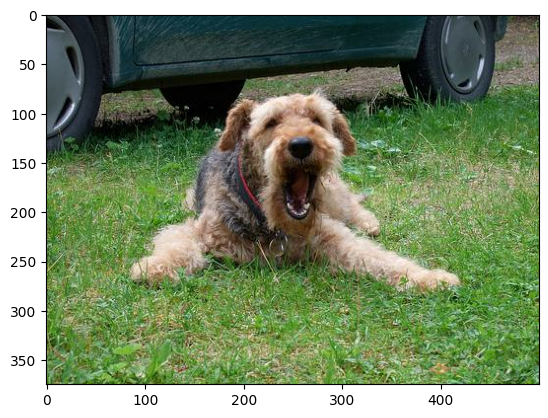

In [24]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

2. 만든 함수로 CAM 이미지를 생성합시다.

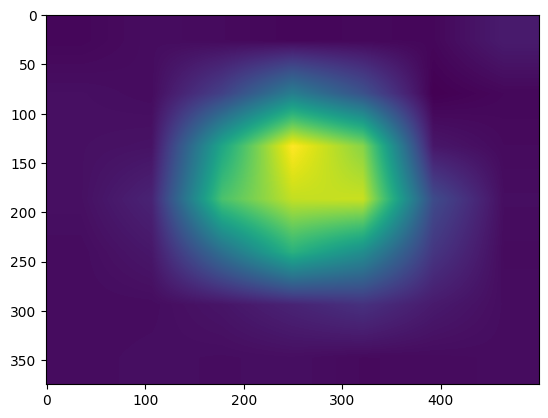

In [26]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()


3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

- [webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

In [ ]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [ ]:
# visualize_cam_on_image() 함수 사용

type(item['image'].numpy())

origin_image = item['image'].numpy().astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)


## Grad-CAM 구현하기
---
1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    grad_cam_image = None
    # TODO: generate grad_cam_image

    return grad_cam_image

2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.

3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

## 바운딩 박스 구하기
---
1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

2. 1)에서 얻은 바운딩 박스를 시각화해 보세요.

## IoU 구하기
---
1. 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.


In [ ]:
def get_iou(gt_bbox, pred_bbox):
    iou = None
    # TODO: get iou between two bbox
    return iou

2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.